### The core Active Learning classes are the Acquisition Functions and its children.
* Assign a utility value to query locations and the greedy algorithm. 
* the algorithm iteratively optimises one sensor placement at a time, rather jointly optimising all placements simultaneously. This breaks the overall N optimisation problem down into smaller, lower-dimensional problems.

### 
This page will use the pre-trained ERA5 spatial interpolation ConvNP from the previous Training page and use DeepSensor’s 
active learning functionality to propose new context locations based on some random initial context locations.

In [1]:
import logging
logging.captureWarnings(True)

import deepsensor.torch
from deepsensor.model import ConvNP
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, get_gldas_land_mask
from deepsensor.train import set_gpu_default_device

import cartopy.crs as ccrs
import pandas as pd

In [3]:
# Training/data config
data_range = ("2010-01-01", "2019-12-31")
train_range = ("2010-01-01", "2018-12-31")
val_range = ("2019-01-01", "2019-12-31")
date_subsample_factor = 2
extent = "north_america"
station_var_IDs = ["TAVG"]
era5_var_IDs = ["2m_temperature"]
lowres_auxiliary_var_IDs = ["elevation"]
cache_dir = "mycache"
deepsensor_folder = "deepsensor_config/"
model_folder = "model"
verbose_download = True

In [4]:
era5_raw_ds = get_era5_reanalysis_data(era5_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir, verbose=verbose_download, num_processes=8)
lowres_aux_raw_ds = get_earthenv_auxiliary_data(lowres_auxiliary_var_IDs, extent, "100KM", cache=True, cache_dir=cache_dir, verbose=verbose_download)
land_mask_raw_ds = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir, verbose=verbose_download)

data_processor = DataProcessor(x1_name="lat", x2_name="lon")
era5_ds = data_processor(era5_raw_ds)
lowres_aux_ds, land_mask_ds = data_processor([lowres_aux_raw_ds, land_mask_raw_ds], method="min_max")

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
lowres_aux_ds["cos_D"] = doy_ds["cos_D"]
lowres_aux_ds["sin_D"] = doy_ds["sin_D"]

100%|██████████| 120/120 [00:01<00:00, 94.49it/s]


1.41 GB loaded in 1.79 s


In [5]:
task_loader = TaskLoader(
    context=[era5_ds, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader.load_dask()
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)


In [6]:
set_gpu_default_device()

In [7]:
# Load model
model = ConvNP(data_processor, task_loader)

dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [np.float32(0.00125), np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


### Initialising a Greedy Algorithm
* the "GreedyAlgorithm" class searches over a set of query context locations, evaluating an AcquisitionFucntion at each query location, adding a context pt and repeating until N_new_context pts have been added.
* Returning proposed context locations as a pandas DataFrame and Acquisition functions in a xarray dataset.

In [8]:
from deepsensor.active_learning import GreedyAlgorithm

In [9]:
alg = GreedyAlgorithm(
    model,
    X_s = era5_raw_ds,
    X_t = era5_raw_ds,
    X_s_mask= land_mask_raw_ds,
    X_t_mask= land_mask_raw_ds,
    context_set_idx= 0,
    target_set_idx=0,
    N_new_context=3,
    progress_bar=True

)

### Initialising an acquisition function.
* Stddev
* This can be used to find locations where the model is most uncertain.
* If an acquisition function is missing, you can easily implement your own by subclassing AcquisitionFunction and implementing the __call__ method.

In [10]:
from deepsensor.active_learning.acquisition_fns import Stddev

In [ ]:
acquisition_fn = Stddev(model, context_set_idx=0, target_set_idx=0) 

### Calling a greedy Algorithm.

* task with context data and acquisition fn.
* if a list of tasks are provided they are ssumed they have different dates and the acquisition fn will be averaged over time when findin gthe best query location.


In [12]:
val_dates = pd.date_range(val_range[0], val_range[1])[::date_subsample_factor]
placement_dates = val_dates
placement_tasks = task_loader(placement_dates, context_sampling=[100, "all", "all"], seed_override=0)
X_new_df, acquisition_fn_ds = alg(acquisition_fn, placement_tasks)

100%|██████████| 549/549 [00:23<00:00, 23.32it/s]


In [13]:
X_new_df

,lat,lon
iteration,,
0,74.75,-89.25
1,74.75,-89.50
2,74.75,-89.75


In [14]:
X_new_df.mean()
X_new_df.std()

lat    0.00
lon    0.25
dtype: float32

In [16]:
#print(placement_tasks)

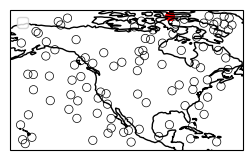

In [15]:
fig = deepsensor.plot.placements(placement_tasks[0], X_new_df, data_processor,
                                 crs = ccrs.PlateCarree())

Averaging acquisition function over dims for plotting: ['time']


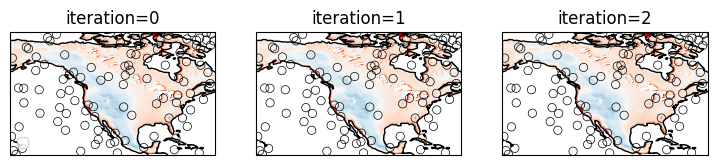

In [16]:
fig = deepsensor.plot.acquisition_fn(placement_tasks[0],
                                     acquisition_fn_ds,
                                     X_new_df,
                                     data_processor,
                                     crs = ccrs.PlateCarree(),
                                     add_colorbar=False,
                                     cmap="RdBu")

# Acquisition Functions

In [19]:
crs = ccrs.PlateCarree()
test_date = pd.Timestamp("2019-06-25")

In [20]:
# Run on GPU if available by setting GPU as default device
set_gpu_default_device()

In [21]:
task_loader = TaskLoader(
    context=[era5_ds, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader.load_dask()
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)


In [22]:
# Load model
model = ConvNP(data_processor, task_loader)

dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [np.float32(0.00125), np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


In [23]:
X_c = 100

In [24]:
task = task_loader(test_date, (X_c, "all", "all"), seed_override=42)

In [25]:
# xarray object containing a mask to remove ocean points from the search and target points
mask_ds = land_mask_raw_ds

### Sequential Greedy Algorithm
* Sequentially loop over all search points, passing a query observation to the model at that point and computing the change in acquisition function.
* computationally expensive
* we will coarsen the search space for the purposes of demonstration.

In [26]:
from deepsensor.active_learning import GreedyAlgorithm

greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds.coarsen(lat=15, lon=15, boundary="trim").mean(),  # Coarsen search points to speed up computation
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    N_new_context=3,
    progress_bar=True
)

### MeanSTDDev

* Minimise the model’s mean standard deviation - i.e. minimise the expected MAE under the model.

  0%|          | 0/579 [00:00<?, ?it/s]

100%|██████████| 579/579 [00:23<00:00, 24.81it/s]


Averaging acquisition function over dims for plotting: ['time']


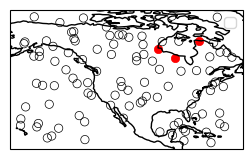

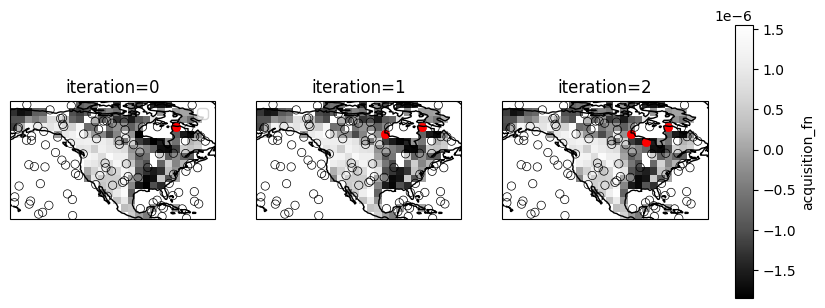

In [27]:
from deepsensor.active_learning.acquisition_fns import MeanStddev

acquisition_fn = MeanStddev(model)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task, diff=True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

In [30]:
print(X_new_df)

             lat    lon
iteration              
0          62.00 -75.75
1          58.25 -94.50
2          54.50 -87.00


In [33]:
X_new_df

,lat,lon
iteration,,
0,62.00,-75.75
1,58.25,-94.50
2,54.50,-87.00


In [32]:
acquisition_fn_ds

<xarray.DataArray 'acquisition_fn' (iteration: 3, time: 1, lat: 16, lon: 26)> Size: 5kB
array([[[[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [-1.3113022e-06, -1.6689301e-06, -1.5497208e-06, ...,
           0.0000000e+00,  0.0000000e+00,            nan],
         [-1.0132790e-06, -1.0132790e-06, -1.7881393e-07, ...,
          -1.7881393e-07, -5.9604645e-07,  1.7881393e-07],
         ...,
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]]],


       [[[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [-1.2516975e-06, -1.6093254e-06, -1.5497208e-06, ...,
          -5.9604645e-08,  0.0000000e+00,            nan],
         [-1.0132790e-06, -1.0132790e-06, -1.7881393e-07, ...,
...
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]]],


       [[[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [-1.1920929e-06, -1.6689301e-06, -1.5497208e-06, ...,
           0.0000000e+00,  0.0000000e+00,            nan],
         [-1.0132790e-06, -1.0132790e-06, -1.7881393e-07, ...,
          -1.7881393e-07, -5.3644180e-07,  1.7881393e-07],
         ...,
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]]]],
      dtype=float32)
Coordinates:
  * iteration  (iteration) int64 24B 0 1 2
  * lat        (lat) float32 64B 73.25 69.5 65.75 62.0 ... 28.25 24.5 20.75 17.0
  * lon        (lon) float32 104B -158.2 -154.5 -150.8 ... -72.0 -68.25 -64.5
  * time       (time) datetime64[ns] 8B 2019-06-25

### pNormStddev
* Computing the p-norm of the standard deviations can be used to place greater emphasis on reducing the largest standard deviations

100%|██████████| 579/579 [00:23<00:00, 24.15it/s]


Averaging acquisition function over dims for plotting: ['time']


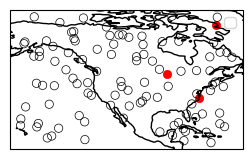

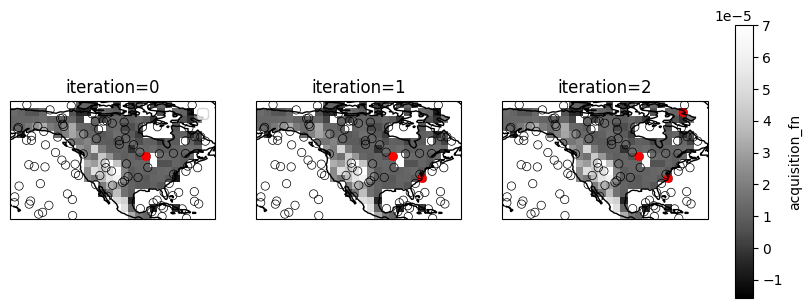

In [64]:
from deepsensor.active_learning.acquisition_fns import pNormStddev

acquisition_fn = pNormStddev(model, p=6)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task, diff=True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

### Oracle Sequential Greedy Algorithm
* This assumes that the true target values are available at all target points, which will often not be the case.
* it can load the true target values for each target point.



In [41]:
greedy_alg_with_groundtruth = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds.coarsen(lat=10, lon=10, boundary="trim").mean(),  # Coarsen search points to speed up computation
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    query_infill=era5_ds,
    proposed_infill=era5_ds,
    N_new_context=3,
    task_loader=task_loader,
    verbose=True,
    progress_bar=True,
)

query_infill not on search grid, interpolating.
proposed_infill not on search grid, interpolating.


### OracleMAE

100%|██████████| 1311/1311 [00:54<00:00, 24.24it/s]


Averaging acquisition function over dims for plotting: ['time']


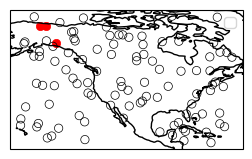

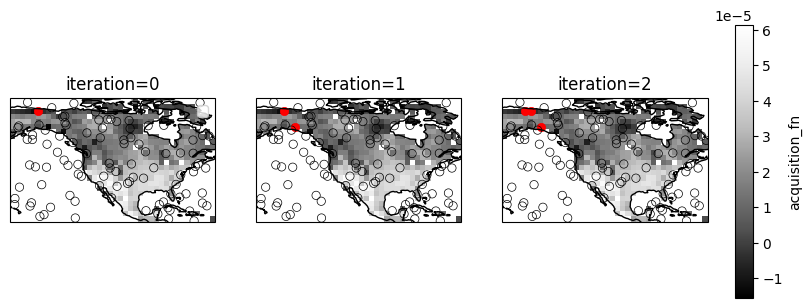

In [42]:
from deepsensor.active_learning.acquisition_fns import OracleMAE

acquisition_fn = OracleMAE(model)
X_new_df, acquisition_fn_ds = greedy_alg_with_groundtruth(acquisition_fn, task, diff=True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

### OracleRMSE

100%|██████████| 1311/1311 [00:54<00:00, 24.17it/s]

Averaging acquisition function over dims for plotting: ['time']


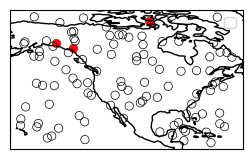

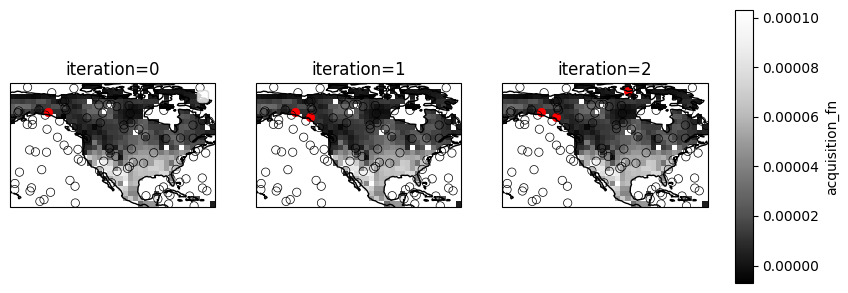

In [43]:
from deepsensor.active_learning.acquisition_fns import OracleRMSE

acquisition_fn = OracleRMSE(model)
X_new_df, acquisition_fn_ds = greedy_alg_with_groundtruth(acquisition_fn, task, diff=True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

### OracleMarginalNLL

100%|██████████| 1311/1311 [01:49<00:00, 11.93it/s]


Averaging acquisition function over dims for plotting: ['time']


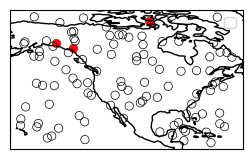

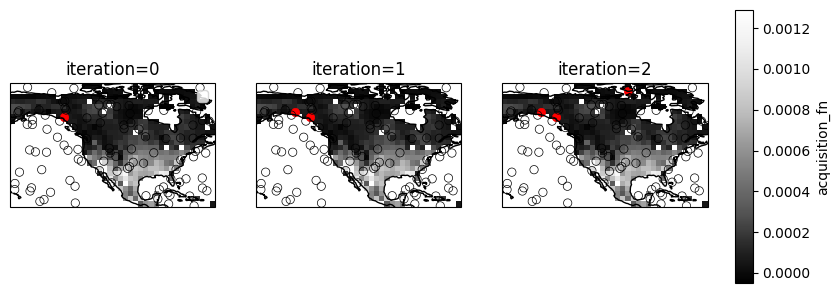

In [44]:
from deepsensor.active_learning.acquisition_fns import OracleMarginalNLL

acquisition_fn = OracleMarginalNLL(model)
X_new_df, acquisition_fn_ds = greedy_alg_with_groundtruth(acquisition_fn, task, diff=True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)


### ParallelGreedyAlgorithm

* Can be computed over all search points in parallel, running the model once.
* This enables finer search grids, averaging acquisition functions over more tasks, and more proposed context points.



In [45]:
greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds,
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    N_new_context=10,
    progress_bar=True,
)

In [46]:
dates = val_dates
tasks = task_loader(dates, (X_c, "all", "all"), seed_override=42)

### Stddev

*  Maximising this acquisition function will place context points at locations where the model is most uncertain.

100%|██████████| 1830/1830 [01:20<00:00, 22.84it/s]


Averaging acquisition function over dims for plotting: ['time']


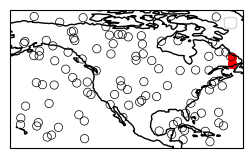

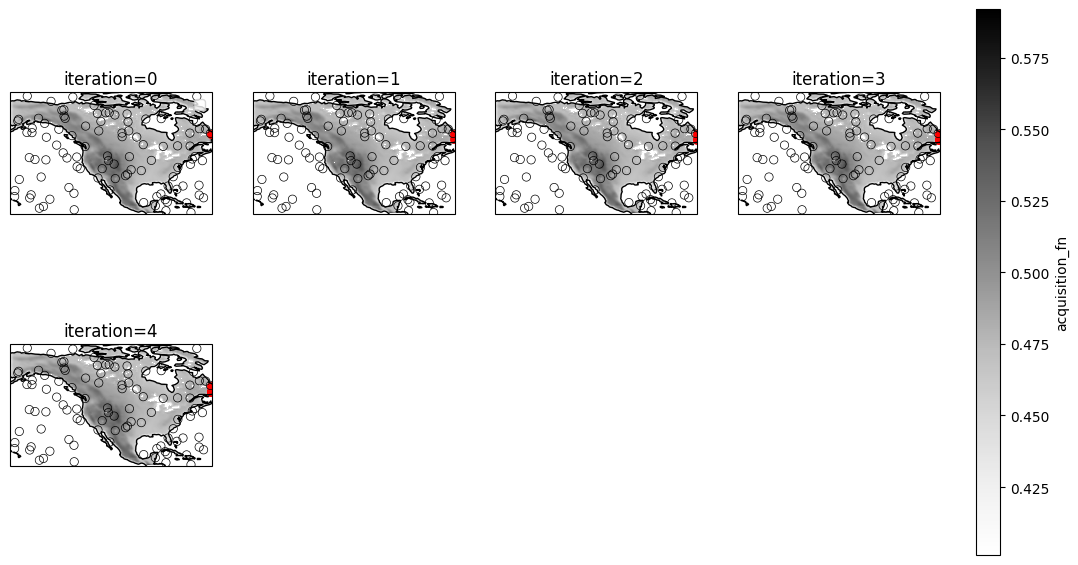

In [50]:
from deepsensor.active_learning.acquisition_fns import Stddev
acquisition_fn = Stddev(model)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, tasks)

fig = deepsensor.plot.placements(tasks[0], X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(tasks[0], acquisition_fn_ds.sel(iteration=slice(0, 4)), X_new_df, data_processor, crs, cmap="Greys", max_ncol=4)

### ExpectedImprovement

* Acquisition function can be used to hunt for the most positive or negative values in the data.
* We will average the acquisition function over tasks sampled from 52 equally spaced dates in 2020 to make the acquisition function more robust to the weather on a single day.



In [51]:
greedy_alg_with_groundtruth = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds,
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    proposed_infill=era5_ds,  # EI requires ground truth after proposal
    N_new_context=10,
    progress_bar=True,
    verbose=True,
)

In [52]:
from deepsensor.active_learning.acquisition_fns import ExpectedImprovement

acquisition_fn = ExpectedImprovement(model)
X_new_df, acquisition_fn_ds = greedy_alg_with_groundtruth(acquisition_fn, tasks)

100%|██████████| 1830/1830 [02:42<00:00, 11.27it/s]


Averaging acquisition function over dims for plotting: ['time']


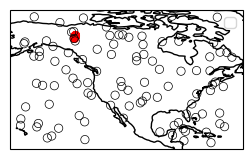

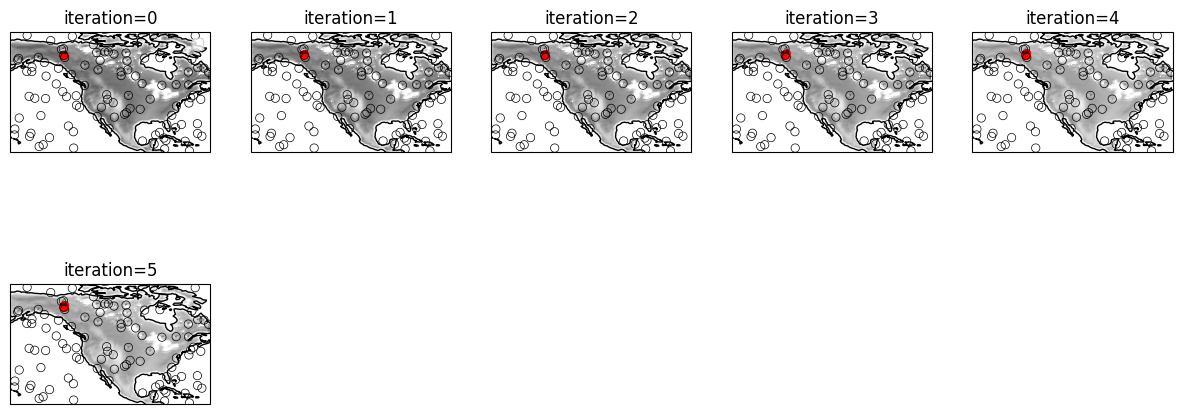

In [53]:
fig = deepsensor.plot.placements(tasks[0], X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(tasks[0], acquisition_fn_ds.sel(iteration=slice(0, 5)), X_new_df, data_processor, crs, cmap="Greys", add_colorbar=False, max_ncol=5)

### Heuristic baseline acquisition functions

* Acquisition functions that don’t use a model can be used as baselines in sensor placement studies.

### ContextDist

* Distance to the closest context point. Maximising this acquisition function will place context points at locations that are furthest from existing context points.



100%|██████████| 10/10 [00:00<00:00, 44.89it/s]


Averaging acquisition function over dims for plotting: ['time']


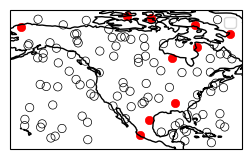

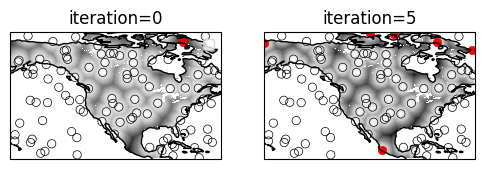

In [54]:
from deepsensor.active_learning.acquisition_fns import ContextDist

acquisition_fn = ContextDist(context_set_idx=0)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, tasks[0])

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(tasks[0], acquisition_fn_ds.sel(iteration=slice(0, 55, 5)), X_new_df, data_processor, crs, cmap="Greys", add_colorbar=False, max_ncol=5)

### Random

* Random acquisition function leading to random placements - a useful baseline!

100%|██████████| 10/10 [00:00<00:00, 613.65it/s]


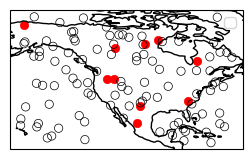

In [57]:
from deepsensor.active_learning.acquisition_fns import Random

acquisition_fn = Random()
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, tasks[0])

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)